## *Last edit by DLao - 2020/09 updated with full data*



















<br>
<br>


![](https://cdn.statically.io/img/thakoni.com/f=auto%2Cq=30/wp-content/uploads/2020/06/1591106722_Lucifer-Season-5-Release-Date-Cast-Netflix-And-Everything-You.jpg)
# Netflix Analytics - Movie Recommendation through Correlations / CF
<br>

I love Netflix! Everyone does?

This project aims to build a movie recommendation mechanism within Netflix. The dataset I used here come directly from Netflix. It consists of 4 text data files, each file contains over 20M rows, i.e. over 4K movies and 400K customers. All together **over 17K movies** and **500K+ customers**! 

<br>
One of the major challenges is to get all these data loaded into the Kernel for analysis, I have encountered many times of Kernel running out of memory and tried many different ways of how to do it more efficiently. Welcome any suggestions!!!

This kernel will be consistently be updated! Welcome any suggestions! Let's get started!

<br>
Feel free to fork and upvote if this notebook is helpful to you in some ways!


## Table of Content:

* Objective

* Data manipulation
    -  Data loading
    -  Data viewing
    -  Data cleaning
    -  Data slicing
    -  Data mapping
    
* Recommendation models
    -  Recommend with Collaborative Filtering (*Edit on 2017/11/07*)
    -  Recommend with Pearsons' R correlation

# Objective
<br>
Learn from data and recommend best TV shows to users, based on self & others behaviour
<br>

# Data manipulation

## Data loading

Each data file (there are 4 of them) contains below columns:

* Movie ID (as first line of each new movie record / file)
* Customer ID
* Rating (1 to 5)
* Date they gave the ratings

There is another file contains the mapping of Movie ID to the movie background like name, year of release, etc

Let's import the library we needed before we get started:

In [1]:
!pip install surprise

In [2]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

Next let's load first data file and get a feeling of how huge the dataset is:

In [3]:
# Skip date
df1 = pd.read_csv('combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


Let's try to load the 3 remaining dataset as well:

In [4]:
# df2 = pd.read_csv('combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df3 = pd.read_csv('combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df4 = pd.read_csv('combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


# df2['Rating'] = df2['Rating'].astype(float)
# df3['Rating'] = df3['Rating'].astype(float)
# df4['Rating'] = df4['Rating'].astype(float)

# print('Dataset 2 shape: {}'.format(df2.shape))
# print('Dataset 3 shape: {}'.format(df3.shape))
# print('Dataset 4 shape: {}'.format(df4.shape))

Now we combine datasets:

In [5]:
# load less data for speed

df = df1
# df = df1.append(df2)
# df = df.append(df3)
# df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


## Data viewing

Let's give a first look on how the data spread:

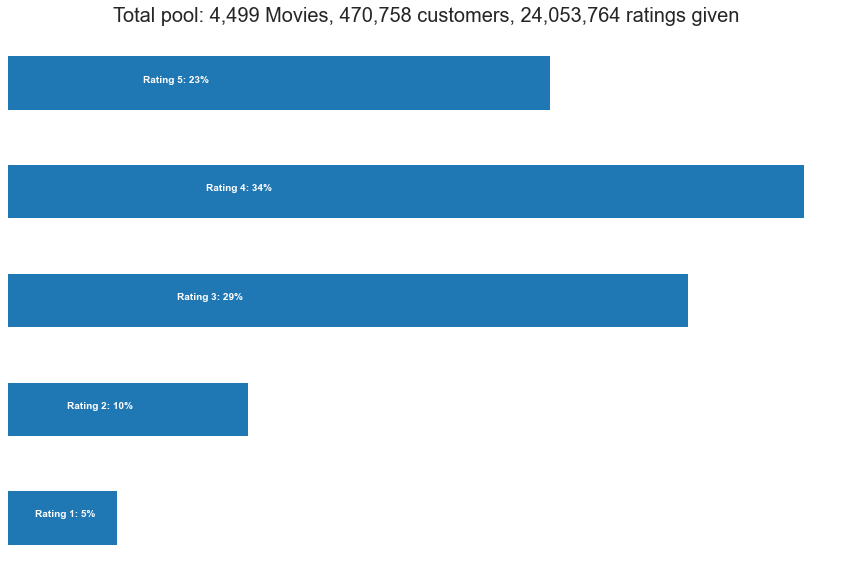

In [6]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')



We can see that the rating tends to be relatively positive (>3). This may be due to the fact that unhappy customers tend to just leave instead of making efforts to rate. We can keep this in mind - low rating movies mean they are generally really bad

## Data cleaning

Movie ID is really a mess import! Looping through dataframe to add Movie ID column WILL make the Kernel run out of memory as it is too inefficient. I achieve my task by first creating a numpy array with correct length then add the whole array as column into the main dataframe! Let's see how it is done below:

In [7]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [8]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])


<ipython-input-8-f9f384b102fb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie_Id'] = movie_np.astype(int)


-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


<ipython-input-8-f9f384b102fb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cust_Id'] = df['Cust_Id'].astype(int)


## Data slicing

The data set now is super huge. I have tried many different ways but can't get the Kernel running as intended without memory error. Therefore I tried to reduce the data volumn by improving the data quality below:

* Remove movie with too less reviews (they are relatively not popular)
* Remove customer who give too less reviews (they are relatively less active)

Having above benchmark will have significant improvement on efficiency, since those unpopular movies and non-active customers still occupy same volumn as those popular movies and active customers in the view of matrix (NaN still occupy space). This should help improve the statistical signifiance too.

Let's see how it is implemented:

In [9]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1799.0
Customer minimum times of review: 52.0


Now let's trim down our data, whats the difference in data size?

In [10]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6932490   1299309     5.0      1384
13860273   400155     3.0      2660
20766530   466962     4.0      3923


Let's pivot the data set and put it into a giant matrix - we need it for our recommendation system:

In [ ]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

# Below is another way I used to sparse the dataframe...doesn't seem to work better

Cust_Id_u = list(sorted(df['Cust_Id'].unique()))
Movie_Id_u = list(sorted(df['Movie_Id'].unique()))
data = df['Rating'].tolist()
row = df['Cust_Id'].astype('category', categories=Cust_Id_u).cat.codes
col = df['Movie_Id'].astype('category', categories=Movie_Id_u).cat.codes
sparse_matrix = csr_matrix((data, (row, col)), shape=(len(Cust_Id_u), len(Movie_Id_u)))
df_p = pd.DataFrame(sparse_matrix.todense(), index=Cust_Id_u, columns=Movie_Id_u)
df_p = df_p.replace(0, np.NaN)


## Data mapping

Now we load the movie mapping file:

In [ ]:
df_title = pd.read_csv('../input/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

# Recommendation models

Well all data required is loaded and cleaned! Next let's get into the recommendation system.

## Recommend with Collaborative Filtering

Evalute performance of [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering), with just first 100K rows for faster process:

In [ ]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

Below is what user 783514 liked in the past:

In [ ]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)


Let's predict which movies user 785314 would love to watch:

In [ ]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

## Recommend with Pearsons' R correlations

The way it works is we use Pearsons' R correlation to measure the linear correlation between review scores of all pairs of movies, then we provide the top 10 movies with highest correlations:

In [ ]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

A recommendation for you if you like 'What the #$*! Do We Know!?'

In [ ]:
recommend("What the #$*! Do We Know!?", 0)

X2: X-Men United:

In [ ]:
recommend("X2: X-Men United", 0)

Hope it is a good read. I will keep updating this Kernel (more models etc). Welcome any suggestions!
